In [ ]:
import nltk
nltk.download('stopwords')
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Fake news detection
LSTM model
"""
import getEmbeddings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras 
from tensorflow.keras import backend as K
import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt
import os
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from collections import Counter
import matplotlib.pyplot as plt



top_words = 5000
epoch_num = 8
batch_size = 128




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# Read the text data
if not os.path.isfile('./xtr_shuffled.npy') or \
    not os.path.isfile('./xte_shuffled.npy') or \
    not os.path.isfile('./ytr_shuffled.npy') or \
    not os.path.isfile('./yte_shuffled.npy'):
    getEmbeddings.clean_data()


xtr = np.load('./xtr_shuffled.npy', allow_pickle=True)
xte = np.load('./xte_shuffled.npy', allow_pickle=True)
y_train = np.load('./ytr_shuffled.npy', allow_pickle=True)
y_test = np.load('./yte_shuffled.npy', allow_pickle=True)

cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  




In [ ]:
# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1



In [ ]:
# Encode the sentences
for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]


y_train = np.where(y_train<1, 1, 0)
y_test = np.where(y_test<1, 1, 0)
y_train = list(y_train)
y_test = list(y_test)


In [ ]:
print(y_train)

[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 

In [ ]:
# Delete the short news
i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

# Generating test data
x_test = []
for x in xte:
    x_test.append(x.split())

# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

# Truncate and pad input sequences
max_review_length = 300
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           160064    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,365
Trainable params: 213,365
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
61/61 [==============================] - 136s 2s/step - loss: 0.5716 - accuracy: 0.7205 - val_loss: 0.3812 - val_accuracy: 0.8544
Epoch 2/8
61/61 [==============================] - 135s 2s/step - loss: 0.2465 - accuracy: 0.9047 - val_loss: 0.2403 - val_accuracy: 0.9045
Epoch 3/8
61/61 [============

In [ ]:
with open('lstm.sav', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://1544bc02-5893-4b5b-9011-60946921a615/assets
INFO:tensorflow:Assets written to: ram://1544bc02-5893-4b5b-9011-60946921a615/assets


In [ ]:
y_pred=model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)


In [ ]:



m = y_test.shape[0]
tp=0
tn=0
fp=0
fn=0
for i in range(m):
    if (y_pred[i]==0 and (y_test[i]!=y_pred[i])):
        fn+=1
    elif (y_pred[i]==1 and (y_test[i]!=y_pred[i])):
        fp+=1
    elif (y_pred[i]==0 and (y_test[i]==y_pred[i])):
        tn+=1
    elif (y_pred[i]==1 and (y_test[i]==y_pred[i])):
        tp+=1

precision=(tp)/(tp+fp)*100
recall=(tp)/(tp+fn)*100
print("Accuracy = " + format((tp+tn)/(tp+tn+fp+fn)*100, '.2f') + "%")   
print("F1-Score = " + format(((2*precision*recall)/(precision+recall)), '.2f') + "%")   
print("Recall = " + format((tp)/(tp+fn)*100, '.2f') + "%")   
print("Precision = " + format((tp)/(tp+fp)*100, '.2f') + "%")   
print("Specificity = " + format((tn)/(tn+fp)*100, '.2f') + "%")  

Accuracy = 90.15%
F1-Score = 89.30%
Recall = 86.07%
Precision = 92.78%
Specificity = 93.87%


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


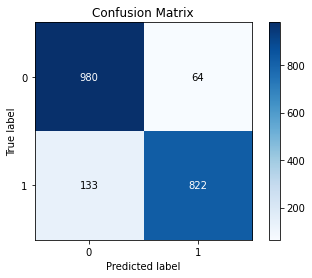

In [ ]:
# Draw the confusion matrix
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.grid(False)
    plt.show()
    
plot_cmat(y_test, y_pred)

In [ ]:
# filename = 'lstm.sav'
# pickle.dump(model, open(filename, 'wb'))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3a2c2a1b-c190-4238-a7b0-93cabb99b4e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>